## Train Classifier: Linear Interpolation and Backoff (LIB) Classification

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_from_disk
from sklearn.metrics import accuracy_score
import random
import numpy as np
import torch
import os

In [16]:
topic = "energie" #"energie" #"kinder" "cannabis"

## Load Dataset

In [17]:
dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_random" )

In [18]:
# Sample 100 random indices from the training dataset
#random_indices = random.sample(range(len(dataset['train'])), 100)

# Select 100 examples from the training dataset
#dataset['train'] = dataset['train'].select(random_indices)

**Extract URL path:**

In [23]:
from urllib.parse import urlparse, urlunparse

def extract_url_path(example):
    view_url = example['view_url']
    if "://" not in view_url:
        view_url = "http://" + view_url  # Assume http if no protocol specified
    parsed_url = urlparse(view_url)
    new_url = urlunparse(('', '', parsed_url.path, parsed_url.params, parsed_url.query, parsed_url.fragment))
    example['url_path'] = new_url.lstrip('/')  # Store the result in a new field
    return example


extract_url_path({"view_url": "https://www.google.com/search?q=python+url+path"})

{'view_url': 'https://www.google.com/search?q=python+url+path',
 'url_path': 'search?q=python+url+path'}

In [24]:
dataset = dataset.map(extract_url_path) # Extract the path from the URL

Map: 100%|██████████| 46/46 [00:00<00:00, 2120.87 examples/s]


In [25]:
# Explore the dataset
print(dataset)
print(dataset['train'][0]) 

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'url_path'],
        num_rows: 408
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'url_path'],
        num_rows: 46
    })
})
{'_id': '64a0946f749484eec85a71bb', 'batch_id': 16, 'domain': 'erneuerbare-energien.de', 'view_url': 'www.erneuerbare-energien.de/EE/Navigation/DE/Foerderung/foerderung.html', 'lang': 'de', 'text': " Link direkt zur Servicenavigation Link direkt zur Hauptnavigation Link direkt zum Inhalt Informationsportal Erneuerbare Energien Startseite Kontakt Impressum Facebook YouTube Twitter Instagram BMWi RSS In\

## Training Phase

The training phase involves:

1. Collecting a corpus of URLs and their associated genres.
2. Extracting n-grams from these URLs.
3. Calculating the frequency of each n-gram for each genre.
4. Estimating the interpolation coefficients (λ) using methods like information gain.
5. Storing these frequencies and coefficients to be used during the prediction phase.


In [26]:
import numpy as np
from collections import defaultdict, Counter
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import normalize

In [27]:
################################# Extract n-grams from a URL #################################

def extract_ngrams(url, n):
    """Extracts n-grams of length n from the given URL."""
    return [url[i:i+n] for i in range(len(url) - n + 1)]

################################# Calculate frequencies of n-grams #################################

def calculate_ngram_frequencies(urls, genres, n_range):
    """Calculates the frequency of n-grams for each genre from the given URLs and genres."""
    
    ngram_freq = defaultdict(lambda: defaultdict(int))
    genre_counts = Counter(genres)
    
    for url, genre in zip(urls, genres):
        for n in n_range:
            ngrams = extract_ngrams(url, n)
            for ngram in ngrams:
                ngram_freq[genre][ngram] += 1
    
    return ngram_freq, genre_counts

################################# Calculate the mutual information for n-grams #################################

def calculate_mutual_information(ngram_freq, genre_counts):
    """Calculates mutual information for n-grams using their frequencies and genre counts."""
    
    ngrams = list({ngram for genre in ngram_freq for ngram in ngram_freq[genre]})
    X = np.zeros((len(ngram_freq), len(ngrams)))
    y = list(genre_counts.keys())

    for i, genre in enumerate(y):
        for j, ngram in enumerate(ngrams):
            X[i, j] = ngram_freq[genre][ngram]
    
    mi = mutual_info_classif(X, y, discrete_features=True)
    return dict(zip(ngrams, mi))

################################# Estimate the interpolation coefficients #################################

def estimate_interpolation_coefficients(ngram_mi, n_range):
    """Estimates interpolation coefficients based on mutual information of n-grams."""
    
    lambda_sum = sum(ngram_mi.values())
    lambdas = {n: 0 for n in n_range}
    
    for ngram, mi in ngram_mi.items():
        n = len(ngram)
        lambdas[n] += mi / lambda_sum
    
    # Normalize the coefficients
    total = sum(lambdas.values())
    for n in lambdas:
        lambdas[n] /= total
    
    return lambdas

################################# Main training function #################################

def train_genre_classifier(urls, genres, n_range=(2, 3, 4)):
    """
    Trains the genre classifier by calculating n-gram frequencies, mutual information,
    and interpolation coefficients from the given URLs and genres.
    """
    # Calculate n-gram frequencies and genre counts
    ngram_freq, genre_counts = calculate_ngram_frequencies(urls, genres, n_range)
    
    # Calculate mutual information for n-grams
    ngram_mi = calculate_mutual_information(ngram_freq, genre_counts)
    
    # Estimate interpolation coefficients
    lambdas = estimate_interpolation_coefficients(ngram_mi, n_range)
    
    return ngram_freq, genre_counts, lambdas

In [29]:
print("URL path:", dataset["test"]["url_path"][0])
print("URL path:", dataset["test"]["label"][0])

URL path: serien/der-schatten
URL path: 0


In [30]:
# urls = [
        
#     # Cannabis-related URLs
#     "bundesgesundheitsministerium.de/themen/cannabis/faq-cannabisgesetz",
#     "de.wikipedia.org/wiki/Cannabis_als_Medizin",
#     "cannabis-med.org/index.php?tpl=cannabis",
    
#     # Children-related URLs
#     "paritaet-bw.de/was-ist-kindergrundsicherung",
#     "kindergesundheit-info.de/themen/entwicklung/alle-entwicklungsbereiche/",
#     "de.wikipedia.org/wiki/Kindergesundheit",
    
#     # Energy-related URLs
#     "https://de.wikipedia.org/wiki/Erneuerbare-Energien-Gesetz",
#     "bmu.de/themen/energie/erneuerbare-energien",
#     "energiewende.de",
    
#     # Other URLs
#     "https://en.wikipedia.org/wiki/Richard_Feynman",
#     "example.com",
#     "other-example.org"
# ]

# genres = ["cannabis", "cannabis", "cannabis", "children", "children", "children", "energy", "energy", "energy", "other", "other", "other"]

urls = dataset["train"]["url_path"]
labels = dataset["train"]["label"]

n_range = (2, 3, 4)

# Train the model
ngram_freq, genre_counts, lambdas = train_genre_classifier(urls, labels, n_range)


## Prediction Phase

The algorithm uses pre-computed (trained) feature sets and probabilities to classify a new instance (URL). It involves:

1. Extracting n-grams from the URL.
2. Using these n-grams to calculate genre probabilities based on pre-learned frequencies and interpolation coefficients.
3. Applying backoff to handle unseen n-grams by considering shorter n-grams.
4. Normalizing the resulting probabilities and selecting the most probable genre.

In [31]:
import numpy as np

In [32]:
################################# Normalize the probabilities #################################

def normalize_probs(probs):
    """Normalizes the probability dictionary so that the probabilities sum to 1."""
    total = sum(probs.values())
    if total == 0:
        return {k: 0 for k in probs}  # Return zero probabilities if total is zero
    return {k: v / total for k, v in probs.items()}

################################# Calculate the probability of an n-gram for a given genre #################################

def calculate_ngram_prob(ngram, genre, ngram_freq, genre_counts, lambdas):
    """
    Calculates the probability of an n-gram given a genre using pre-trained frequencies and interpolation coefficients.
    """
    n = len(ngram)
    lambda_n = lambdas.get(n, 0)
    freq = ngram_freq[genre].get(ngram, 0)
    total_ngrams = sum(ngram_freq[genre].values())
    if total_ngrams == 0:
        return 1e-10  # Return a small non-zero value if no n-grams are found
    prob = (lambda_n * (freq / total_ngrams))
    return prob

################################# Extract n-grams from a URL #################################

def extract_ngrams(url, n):
    """Extracts n-grams of length n from the given URL."""
    return [url[i:i+n] for i in range(len(url) - n + 1)]

################################# Prediction function #################################

def predict_genre(url, ngram_freq, genre_counts, lambdas, n_range=(2, 3, 4)):
    """
    Predicts the genre of a given URL using pre-trained n-gram frequencies, genre counts, and interpolation coefficients.
    """
    probs = {genre: np.log(count / sum(genre_counts.values())) if count > 0 else -np.inf for genre, count in genre_counts.items()}
    Q = []
    grams = set()
    
    for n in n_range:
        Q.extend(extract_ngrams(url, n))
    
    while Q:
        gram = Q.pop(0)
        if any(gram in ngram_freq[genre] for genre in genre_counts):
            grams.add(gram)
        else:
            if len(gram) > min(n_range):
                Q.append(gram[:-1])
    
    if grams:
        for genre in genre_counts:
            for gram in grams:
                ngram_prob = calculate_ngram_prob(gram, genre, ngram_freq, genre_counts, lambdas)
                if ngram_prob > 0:
                    probs[genre] += np.log(ngram_prob)
    
    probs = normalize_probs(probs)
    predicted_genre = max(probs, key=probs.get)
    
    return predicted_genre, probs


**Make Precitions:**

In [53]:
urls_test = dataset["test"]["url_path"]
labels_test = dataset["test"]["label"]

In [60]:
# Predict the genre of a new URL
url_id = 25
new_url = urls_test[url_id]
url_label = labels_test[url_id]
print("Test URL:", new_url)
predicted_genre, probabilities = predict_genre(new_url, ngram_freq, genre_counts, lambdas, n_range)

print("True Category:", url_label)
print("Predicted Category:", predicted_genre)
print("Category Probabilities:", probabilities)

Test URL: EE/Redaktion/DE/Dossier/eeg.html
True Category: 1
Predicted Category: 1
Category Probabilities: {1: 0.5908990751488342, 0: 0.40910092485116584}


In [51]:
def add_genre_prediction(example):
    prediction, probabilities = predict_genre(example["url_path"], ngram_freq, genre_counts, lambdas)
    example["preds"] = prediction
    example["probas"] = list(probabilities.values())
    return example

dataset["test"] = dataset["test"].map(add_genre_prediction)

Map: 100%|██████████| 46/46 [00:07<00:00,  6.42 examples/s]


In [52]:
dataset["test"][0]

{'_id': '64a0946e749484eec8578700',
 'batch_id': 16,
 'domain': 'zdf.de',
 'view_url': 'zdf.de/serien/der-schatten',
 'lang': 'de',
 'text': ' Zum Hauptinhalt springen Zur Suche springen Zweites Deutsches Fernsehen Menü Hauptnavigation Startseite Rubriken Filme Serien Comedy & Satire heute-Nachrichten Politik & Gesellschaft Sport Dokus & Reportagen Kultur ZDFtivi für Kinder Sendungen A-Z TV-Programm Karriere im ZDF Barrierefrei Live-TV Sendung verpasst Dunkler Modus Heller Modus Suche Mein ZDF Meine Merkliste Weiterschauen Benachrichtigungen Mein ZDFtivi Einstellungen Anmelden abmelden Suche Suchbegriff Suchen Gesamtes Angebot ZDF ZDFinfo ZDFneo ZDFheute ZDFkultur ZDFtivi 3sat Arte Funk Kika Phoenix Weitere Filter von bis ganze Sendungen AD UT DGS Thrillerserie Thrillerserie 6 Folgen Sie sind hier: zdf.de Serien Der Schatten Eine dunkle Prophezeiung Journalistin Norah wagt in Wien einen Neuanfang. Kaum angekommen, prophezeit ihr eine Bettlerin, sie werde einen Mann töten. Sie schenkt d

## Evaluate

In [61]:
labels = dataset["test"]["label"]
preds = dataset["test"]["preds"]

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 89.13%
Precision: 0.85
Recall: 0.96
F1 Score: 0.90


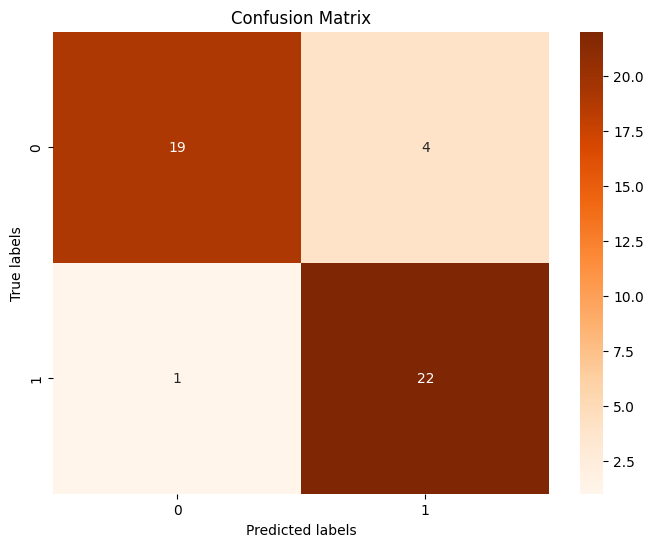

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
cm = confusion_matrix(labels, preds)

# Create a seaborn heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)

# Add labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()
